In [1]:
!python -m pip install --user --upgrade pip
!pip install --user keras
!pip install --user tensorflow
!pip install --user -U numpy

distributed 1.21.8 requires msgpack, which is not installed.
You are using pip version 10.0.1, however version 19.2.2 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


  Created wheel for absl-py: filename=absl_py-0.7.1-cp36-none-any.whl size=113722 sha256=3b7ab3141026d9deab3d785655ac0710324b2912e97a2ab5b81fde56ea6897d3
  Stored in directory: C:\Users\mayingzh\AppData\Local\pip\Cache\wheels\ee\98\38\46cbcc5a93cfea5492d19c38562691ddb23b940176c14f7b48
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=6594 sha256=6960518bb5c0e97ca75ffe4c9e2ded5115edd8a582df116141067f90da79db8e
  Stored in directory: C:\Users\mayingzh\AppData\Local\pip\Cache\wheels\5c\2e\7e\a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
  Created wheel for wrapt: filename=wrapt-1.11.2-cp36-none-any.whl size=18733 sha256=5176b75e4d9745e980539f2d90ddcebb542f87a2d289206495c3128aa813c55a
  Stored in directory: C:\Users\mayingzh\AppData\Local\pip\Cache\wheels\d7\de\2e\efa132238792efb6459a96e85916ef8597fcb3d2ae51590dfd
  Created wheel for termcolor: filename=termcolor-1.1.0-cp36-none-any.whl size=4006 sha256=683d3e5071f9a400da65862dbb17bf5057ec80cce8a7d42c3d364f428b567b9

ERROR: tensorboard 1.14.0 has requirement setuptools>=41.0.0, but you'll have setuptools 39.1.0 which is incompatible.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


Requirement already up-to-date: numpy in c:\users\mayingzh\appdata\roaming\python\python36\site-packages (1.17.0)


In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers.advanced_activations import PReLU, ELU
from keras.layers.normalization import BatchNormalization
from keras import backend as K
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasRegressor
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import sklearn.metrics as skm, math
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\mayingzh\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\mayingzh\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\mayingzh\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\mayingzh\AppData\Roaming\Python\Py

# Model Building

## Load data and do data normalization

In [2]:
def moneyness(S,X):
    return S/X

In [3]:
def intrinsic(S, K, C, P):
    return C*(max(S-K, 0)) + P*(max(K-S, 0))

In [4]:
def load_data(file):
    df = pd.read_csv(file)
    df = df.dropna()
    
    # Remove the option data has less than 7 days to maturity.
    df = df[df.maturity > 6]
    
    df['moneyness'] = df.apply(lambda row: moneyness(row['underlying_price'], row['strike_price']), axis = 1)
    df = df[df.moneyness >= 0.5]
    df = df[df.moneyness <= 1.5]
    
    # Calculate the intrinsic value of all the options
    df['intrinsic'] = df.apply(lambda row: intrinsic(row['underlying_price'], row['strike_price'], row['cp_flag_C'], row['cp_flag_P']), axis = 1)
    
    sample_df = df[['strike_price', 'underlying_price', 'maturity', 'impl_volatility', 'realized_vol', 'cp_flag_C', 'cp_flag_P', 
                    'interest_rate', 'intrinsic', 'moneyness', 'best_offer']].apply(pd.to_numeric)
    sample_df = sample_df.reset_index(drop=True)
    
    ITM_df = sample_df[sample_df['moneyness'] <= 0.97]
    ATM_df = sample_df[sample_df['moneyness'].between(0.97, 1.03, inclusive = False)]
    OTM_df = sample_df[sample_df['moneyness'] >= 1.03]
    
    return sample_df, ITM_df, ATM_df, OTM_df

In [5]:
sample_df, ITM_df, ATM_df, OTM_df = load_data('Options_R_new.csv')

In [6]:
print('In-The_Money option data shape:', ITM_df.shape)
print('An-The_Money option data shape:', ATM_df.shape)
print('Out-The_Money option data shape:', OTM_df.shape)

In-The_Money option data shape: (687300, 11)
An-The_Money option data shape: (262052, 11)
Out-The_Money option data shape: (750883, 11)


In [45]:
def get_corr(sample_df):
    corr_matrix = sample_df.corr()
    
    fig = plt.figure(figsize = (10,10))
    sns.heatmap(corr_matrix, vmax = .8, square = True)
    plt.show()
    
    corr = corr_matrix['best_offer'].sort_values(ascending=False)
    print(corr)
    
    return corr

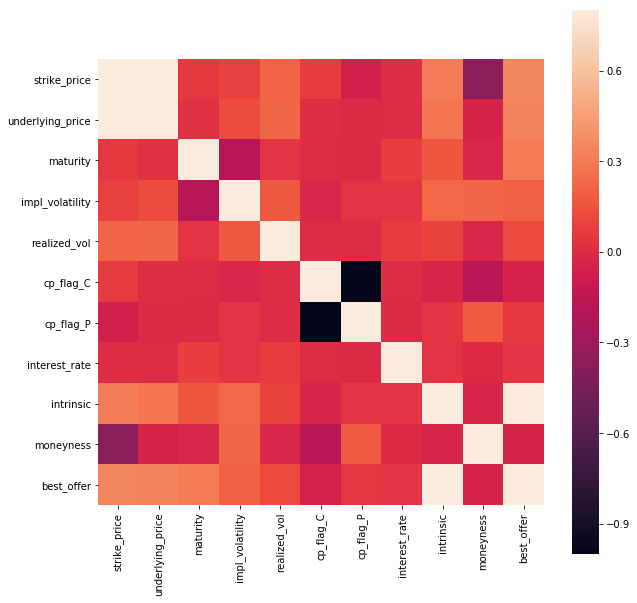

best_offer          1.000000
intrinsic           0.976694
strike_price        0.345604
underlying_price    0.332923
maturity            0.301267
impl_volatility     0.196128
realized_vol        0.118990
cp_flag_P           0.047227
interest_rate       0.038505
moneyness          -0.038097
cp_flag_C          -0.047227
Name: best_offer, dtype: float64


In [46]:
corr = get_corr(sample_df)

In [7]:
def data(s_df):
    
    y = s_df['best_offer'].values
    X = s_df[['intrinsic', 'strike_price', 'underlying_price', 'maturity', 'impl_volatility', 'cp_flag_P', 'interest_rate',]]
    
    sc_X = StandardScaler()
    sc_X.fit(X)
    X_scale = sc_X.fit_transform(X)

    sc_y = StandardScaler()
    y = y.reshape(-1,1)
    sc_y.fit(y)
    y_scale = sc_y.fit_transform(y)

    X_train, X_test, y_train, y_test = train_test_split(X_scale, y_scale, test_size=0.2, random_state=42)
    
    return X_train, X_test, y_train, y_test, sc_X, sc_y

## Build model with in-the-money option data

In [24]:
X_train_ITM, X_test_ITM, y_train_ITM, y_test_ITM, sc_X_ITM, sc_y_ITM = data(ITM_df.sample(frac=0.8))

In [25]:
y_test_ITM[:10]

array([[-0.55107401],
       [ 0.32072701],
       [-0.29383226],
       [ 0.01848475],
       [-0.55443226],
       [-0.53025287],
       [-0.54704411],
       [ 2.41627337],
       [ 0.29386103],
       [-0.50943174]])

In [11]:
# Because it is a simple regression problem, we should custom metrics function
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis = -1))

def r_square(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return (1 - SS_res/(SS_tot + K.epsilon()))

def ABS(x):
    return K.abs(x)

def exp(x):
    return K.exp(x)

In [17]:
def create_model(X, y):#neurons_1=1,learn_rate=0.01):
    
    model = Sequential()
    
    es = EarlyStopping(monitor='val_loss', min_delta=0, patience=25, verbose=0, mode='auto')
    
    model.add(Dense(50, input_shape = (7,), activation = 'relu'))
    model.add(Dense(100, activation = 'relu'))
    model.add(Dense(300, activation = 'elu'))
    model.add(Dense(500, activation = 'relu'))
    model.add(Dense(100, activation = 'elu'))
    model.add(Dense(1, activation = 'linear'))
    
    #optimizer = Adam()
    model.compile(optimizer = 'adam', loss = 'mse', metrics = ['mae'])
    
    result = model.fit(X,y, epochs = 200, batch_size = 1024, validation_split = 0.1, verbose = 1, callbacks = [es])
    
    # plot training curve for rmse
    plt.figure(figsize = (14, 10))
    plt.plot(result.history['loss'])
    plt.plot(result.history['val_loss'])
    plt.title('Loss(mse) converge')
    plt.ylabel('Loss(mse)')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()
    
    return model, result

Train on 395884 samples, validate on 43988 samples
Epoch 1/200
395884/395884 [==============================] - 7s 18us/step - loss: 0.0134 - mean_absolute_error: 0.0482 - val_loss: 0.0011 - val_mean_absolute_error: 0.0218
Epoch 2/200
395884/395884 [==============================] - 7s 18us/step - loss: 9.6343e-04 - mean_absolute_error: 0.0204 - val_loss: 8.6056e-04 - val_mean_absolute_error: 0.0196
Epoch 3/200
395884/395884 [==============================] - 7s 17us/step - loss: 8.0943e-04 - mean_absolute_error: 0.0183 - val_loss: 8.3457e-04 - val_mean_absolute_error: 0.0178
Epoch 4/200
395884/395884 [==============================] - 7s 17us/step - loss: 7.5491e-04 - mean_absolute_error: 0.0172 - val_loss: 6.2777e-04 - val_mean_absolute_error: 0.0164
Epoch 5/200
395884/395884 [==============================] - 7s 18us/step - loss: 7.3227e-04 - mean_absolute_error: 0.0167 - val_loss: 6.6549e-04 - val_mean_absolute_error: 0.0157
Epoch 6/200
395884/395884 [==============================

395884/395884 [==============================] - 6s 16us/step - loss: 4.5930e-04 - mean_absolute_error: 0.0122 - val_loss: 4.6799e-04 - val_mean_absolute_error: 0.0132
Epoch 47/200
395884/395884 [==============================] - 6s 16us/step - loss: 4.4481e-04 - mean_absolute_error: 0.0119 - val_loss: 0.0012 - val_mean_absolute_error: 0.0189
Epoch 48/200
395884/395884 [==============================] - 6s 16us/step - loss: 4.5598e-04 - mean_absolute_error: 0.0122 - val_loss: 4.5098e-04 - val_mean_absolute_error: 0.0118
Epoch 49/200
395884/395884 [==============================] - 6s 16us/step - loss: 4.5571e-04 - mean_absolute_error: 0.0121 - val_loss: 4.2637e-04 - val_mean_absolute_error: 0.0118
Epoch 50/200
395884/395884 [==============================] - 6s 16us/step - loss: 4.5490e-04 - mean_absolute_error: 0.0121 - val_loss: 4.6806e-04 - val_mean_absolute_error: 0.0130
Epoch 51/200
395884/395884 [==============================] - 6s 16us/step - loss: 4.5207e-04 - mean_absolute_er

395884/395884 [==============================] - 6s 16us/step - loss: 4.1422e-04 - mean_absolute_error: 0.0114 - val_loss: 4.1064e-04 - val_mean_absolute_error: 0.0108
Epoch 92/200
395884/395884 [==============================] - 6s 16us/step - loss: 3.9086e-04 - mean_absolute_error: 0.0109 - val_loss: 3.7712e-04 - val_mean_absolute_error: 0.0103
Epoch 93/200
395884/395884 [==============================] - 6s 16us/step - loss: 3.9853e-04 - mean_absolute_error: 0.0110 - val_loss: 4.8343e-04 - val_mean_absolute_error: 0.0116
Epoch 94/200
395884/395884 [==============================] - 6s 16us/step - loss: 3.9928e-04 - mean_absolute_error: 0.0110 - val_loss: 3.9310e-04 - val_mean_absolute_error: 0.0105
Epoch 95/200
395884/395884 [==============================] - 6s 16us/step - loss: 3.8545e-04 - mean_absolute_error: 0.0108 - val_loss: 4.2766e-04 - val_mean_absolute_error: 0.0120
Epoch 96/200
395884/395884 [==============================] - 6s 16us/step - loss: 4.0327e-04 - mean_absolut

395884/395884 [==============================] - 6s 16us/step - loss: 3.6206e-04 - mean_absolute_error: 0.0104 - val_loss: 3.8316e-04 - val_mean_absolute_error: 0.0109
Epoch 137/200
395884/395884 [==============================] - 6s 16us/step - loss: 3.6844e-04 - mean_absolute_error: 0.0105 - val_loss: 4.7083e-04 - val_mean_absolute_error: 0.0117
Epoch 138/200
395884/395884 [==============================] - 6s 16us/step - loss: 3.6898e-04 - mean_absolute_error: 0.0105 - val_loss: 4.0422e-04 - val_mean_absolute_error: 0.0121
Epoch 139/200
395884/395884 [==============================] - 6s 16us/step - loss: 3.5916e-04 - mean_absolute_error: 0.0103 - val_loss: 4.6148e-04 - val_mean_absolute_error: 0.0118
Epoch 140/200
395884/395884 [==============================] - 6s 16us/step - loss: 3.6341e-04 - mean_absolute_error: 0.0103 - val_loss: 3.7557e-04 - val_mean_absolute_error: 0.0105
Epoch 141/200
395884/395884 [==============================] - 7s 17us/step - loss: 3.7004e-04 - mean_ab

395884/395884 [==============================] - 6s 16us/step - loss: 3.4115e-04 - mean_absolute_error: 0.0099 - val_loss: 3.5020e-04 - val_mean_absolute_error: 0.0096
Epoch 182/200
395884/395884 [==============================] - 6s 16us/step - loss: 3.4190e-04 - mean_absolute_error: 0.0099 - val_loss: 4.0002e-04 - val_mean_absolute_error: 0.0103
Epoch 183/200
395884/395884 [==============================] - 6s 16us/step - loss: 3.5460e-04 - mean_absolute_error: 0.0102 - val_loss: 3.9487e-04 - val_mean_absolute_error: 0.0107
Epoch 184/200
395884/395884 [==============================] - 6s 16us/step - loss: 3.4908e-04 - mean_absolute_error: 0.0101 - val_loss: 3.6088e-04 - val_mean_absolute_error: 0.0108
Epoch 185/200
395884/395884 [==============================] - 6s 16us/step - loss: 3.4511e-04 - mean_absolute_error: 0.0100 - val_loss: 3.8572e-04 - val_mean_absolute_error: 0.0102
Epoch 186/200
395884/395884 [==============================] - 6s 16us/step - loss: 3.3940e-04 - mean_ab

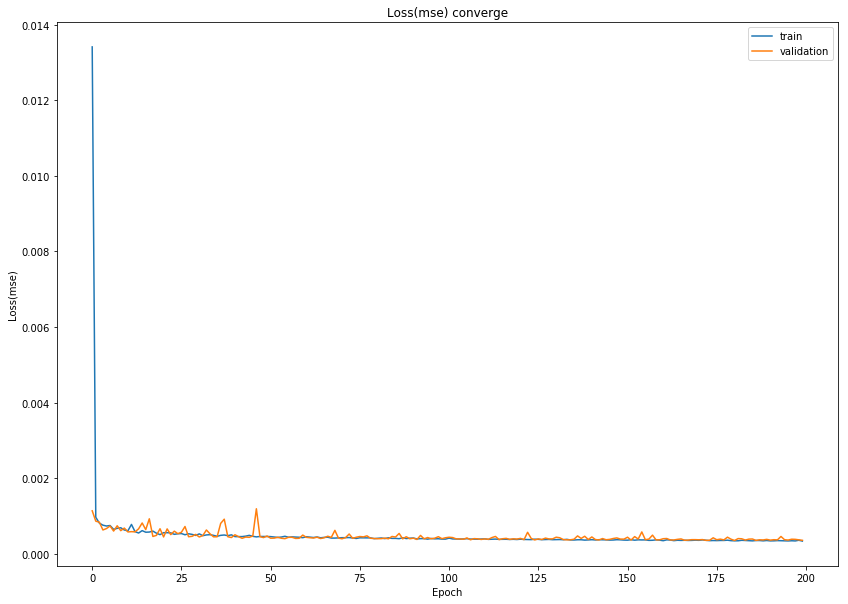

Wall time: 21min 31s


In [26]:
%time model_ITM, result_ITM = create_model(X_train_ITM, y_train_ITM)

In [27]:
def pred(model, X, y, sc_X, sc_y):
    
    pred = model.predict(X)

    pred = sc_y.inverse_transform(pred)
    y = sc_y.inverse_transform(y)

    pred = pred.flatten()
    y = y.flatten()

    d = {'predicted': pred, 'actual': y}
    pred_df = pd.DataFrame(data = d)
    display(pred_df.head(10))

    pred_sample = pred_df.sample(n = 150)

    pred_sample.sort_index(axis = 0, inplace = True)
    
    plt.figure(figsize = (15,10))
    plt.plot(pred_sample.index, pred_sample['predicted'], linestyle = '-', label = 'predicted', color = 'r')
    plt.plot(pred_sample.index, pred_sample['actual'], linestyle = '-', label = 'actual', alpha = 0.5)
    plt.ylabel('price', fontsize = 20)
    plt.legend(prop={'size': 20})
    plt.title('Predicted vs Actual Values', fontsize = 30)
    plt.show()

    print("Mean absolute error (MAE): %f" % skm.mean_absolute_error(y,pred))
    print("Mean squared error (MSE):  %f" % skm.mean_squared_error(y,pred))
    print("R square (R^2):            %f" % skm.r2_score(y,pred))

,predicted,actual
0,0.056684,0.07
1,13.442595,13.05
2,4.011504,3.90
3,8.510058,8.55
4,0.025951,0.02
5,0.354992,0.38
6,0.180825,0.13
7,44.042473,44.25
8,12.976254,12.65
9,0.726853,0.69


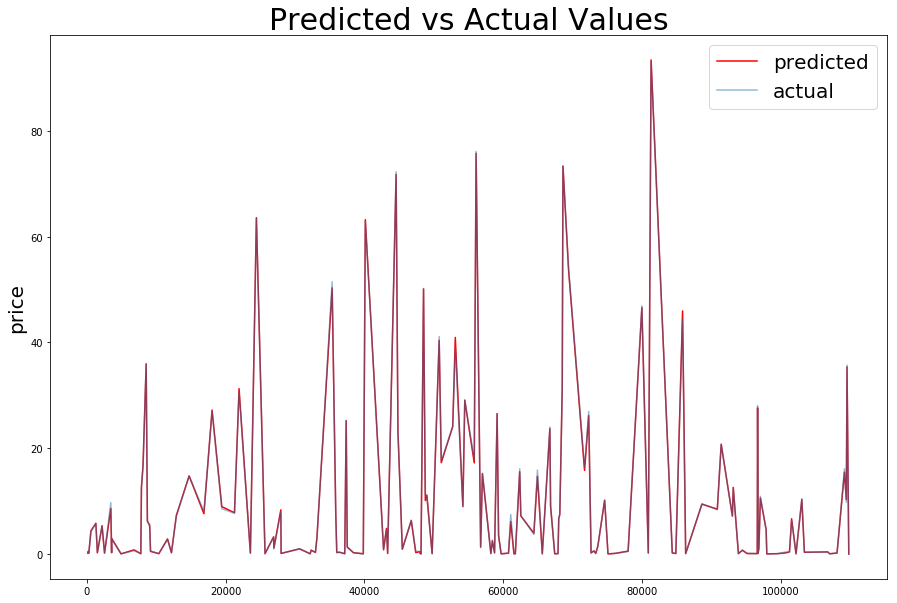

Mean absolute error (MAE): 0.147508
Mean squared error (MSE):  0.078077
R square (R^2):            0.999644


In [28]:
pred_ITM = pred(model_ITM, X_test_ITM, y_test_ITM, sc_X_ITM, sc_y_ITM)

In [29]:
model_ITM.save('model4_2_ITM.h5')

## Build model with at-the-money option data

In [30]:
X_train_ATM, X_test_ATM, y_train_ATM, y_test_ATM, sc_X_ATM, sc_y_ATM = data(ATM_df)

Train on 188676 samples, validate on 20965 samples
Epoch 1/200
188676/188676 [==============================] - 4s 20us/step - loss: 0.0396 - mean_absolute_error: 0.1186 - val_loss: 0.0142 - val_mean_absolute_error: 0.0836
Epoch 2/200
188676/188676 [==============================] - 3s 16us/step - loss: 0.0111 - mean_absolute_error: 0.0752 - val_loss: 0.0094 - val_mean_absolute_error: 0.0694
Epoch 3/200
188676/188676 [==============================] - 3s 17us/step - loss: 0.0091 - mean_absolute_error: 0.0686 - val_loss: 0.0091 - val_mean_absolute_error: 0.0680
Epoch 4/200
188676/188676 [==============================] - 3s 17us/step - loss: 0.0078 - mean_absolute_error: 0.0635 - val_loss: 0.0069 - val_mean_absolute_error: 0.0599
Epoch 5/200
188676/188676 [==============================] - 3s 17us/step - loss: 0.0067 - mean_absolute_error: 0.0588 - val_loss: 0.0071 - val_mean_absolute_error: 0.0588
Epoch 6/200
188676/188676 [==============================] - 3s 16us/step - loss: 0.0062 

188676/188676 [==============================] - 3s 18us/step - loss: 0.0021 - mean_absolute_error: 0.0315 - val_loss: 0.0020 - val_mean_absolute_error: 0.0312
Epoch 49/200
188676/188676 [==============================] - 3s 17us/step - loss: 0.0021 - mean_absolute_error: 0.0315 - val_loss: 0.0021 - val_mean_absolute_error: 0.0310
Epoch 50/200
188676/188676 [==============================] - 3s 17us/step - loss: 0.0021 - mean_absolute_error: 0.0314 - val_loss: 0.0023 - val_mean_absolute_error: 0.0313
Epoch 51/200
188676/188676 [==============================] - 3s 17us/step - loss: 0.0020 - mean_absolute_error: 0.0308 - val_loss: 0.0022 - val_mean_absolute_error: 0.0318
Epoch 52/200
188676/188676 [==============================] - 3s 18us/step - loss: 0.0021 - mean_absolute_error: 0.0311 - val_loss: 0.0024 - val_mean_absolute_error: 0.0357
Epoch 53/200
188676/188676 [==============================] - 3s 17us/step - loss: 0.0020 - mean_absolute_error: 0.0306 - val_loss: 0.0028 - val_mea

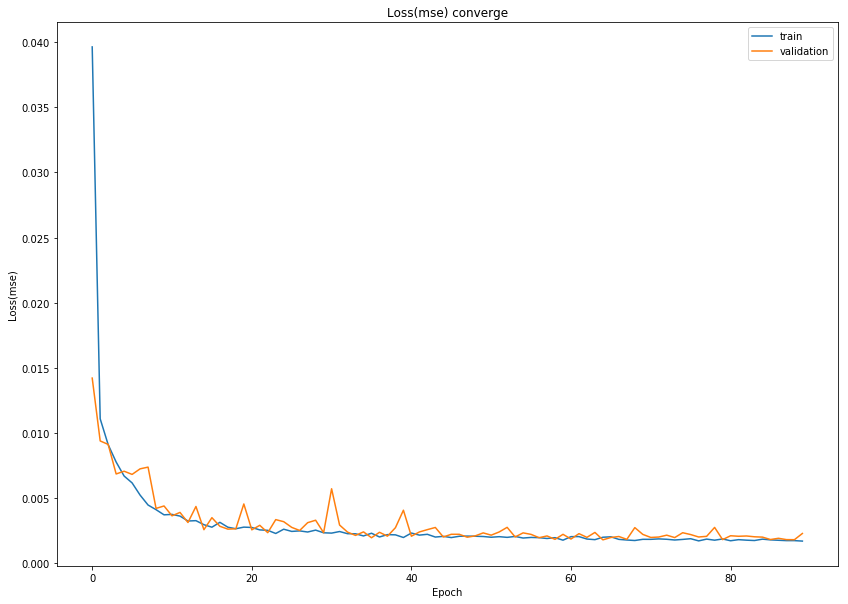

Wall time: 4min 47s


In [31]:
%time model_ATM, result_ATM = create_model(X_train_ATM, y_train_ATM)

,predicted,actual
0,0.928348,0.88
1,1.956799,1.93
2,7.586806,7.70
3,3.370148,3.45
4,0.546027,0.62
5,0.664540,0.59
6,1.401006,1.38
7,0.495582,0.53
8,2.567116,2.49
9,0.453328,0.44


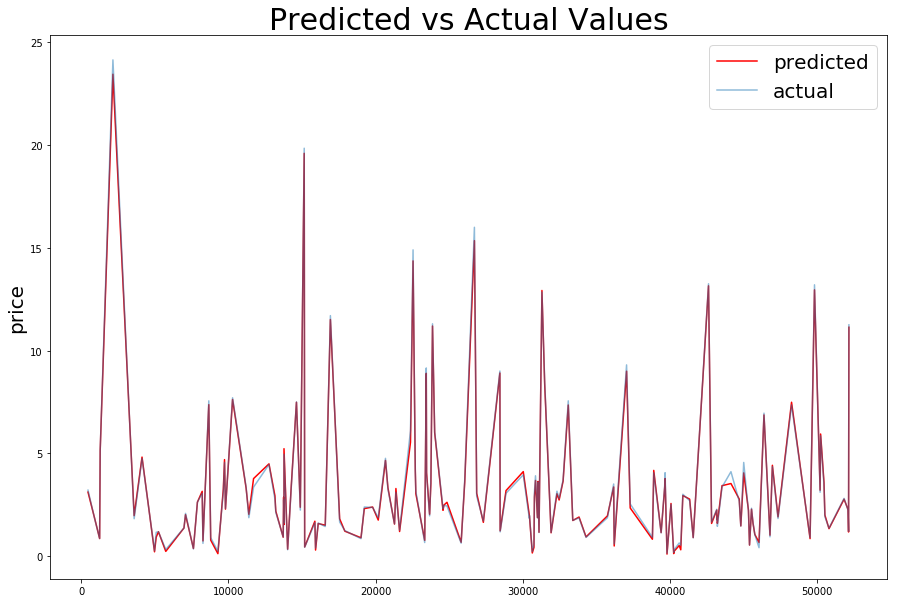

Mean absolute error (MAE): 0.112620
Mean squared error (MSE):  0.029645
R square (R^2):            0.997789


In [32]:
pred_ATM = pred(model_ATM, X_test_ATM, y_test_ATM, sc_X_ATM, sc_y_ATM)

In [33]:
model_ATM.save('model4_2_ATM.h5')

## Build model with out-the-money option data

In [34]:
X_train_OTM, X_test_OTM, y_train_OTM, y_test_OTM, sc_X_OTM, sc_y_OTM = data(OTM_df.sample(frac=0.8))

Train on 432507 samples, validate on 48057 samples
Epoch 1/200
432507/432507 [==============================] - 8s 18us/step - loss: 0.0094 - mean_absolute_error: 0.0453 - val_loss: 0.0023 - val_mean_absolute_error: 0.0308
Epoch 2/200
432507/432507 [==============================] - 7s 17us/step - loss: 0.0012 - mean_absolute_error: 0.0228 - val_loss: 0.0011 - val_mean_absolute_error: 0.0220
Epoch 3/200
432507/432507 [==============================] - 8s 17us/step - loss: 9.3864e-04 - mean_absolute_error: 0.0199 - val_loss: 9.2801e-04 - val_mean_absolute_error: 0.0204
Epoch 4/200
432507/432507 [==============================] - 7s 16us/step - loss: 8.8333e-04 - mean_absolute_error: 0.0191 - val_loss: 9.0742e-04 - val_mean_absolute_error: 0.0186
Epoch 5/200
432507/432507 [==============================] - 7s 17us/step - loss: 8.8012e-04 - mean_absolute_error: 0.0189 - val_loss: 7.3131e-04 - val_mean_absolute_error: 0.0172
Epoch 6/200
432507/432507 [==============================] - 7s 1

432507/432507 [==============================] - 7s 16us/step - loss: 5.4822e-04 - mean_absolute_error: 0.0137 - val_loss: 5.3552e-04 - val_mean_absolute_error: 0.0140
Epoch 47/200
432507/432507 [==============================] - 7s 16us/step - loss: 5.5097e-04 - mean_absolute_error: 0.0137 - val_loss: 5.7429e-04 - val_mean_absolute_error: 0.0137
Epoch 48/200
432507/432507 [==============================] - 7s 16us/step - loss: 5.4487e-04 - mean_absolute_error: 0.0136 - val_loss: 5.6380e-04 - val_mean_absolute_error: 0.0137
Epoch 49/200
432507/432507 [==============================] - 7s 16us/step - loss: 5.4949e-04 - mean_absolute_error: 0.0136 - val_loss: 6.2692e-04 - val_mean_absolute_error: 0.0145
Epoch 50/200
432507/432507 [==============================] - 7s 16us/step - loss: 5.4966e-04 - mean_absolute_error: 0.0136 - val_loss: 5.8764e-04 - val_mean_absolute_error: 0.0154
Epoch 51/200
432507/432507 [==============================] - 7s 16us/step - loss: 5.2631e-04 - mean_absolut

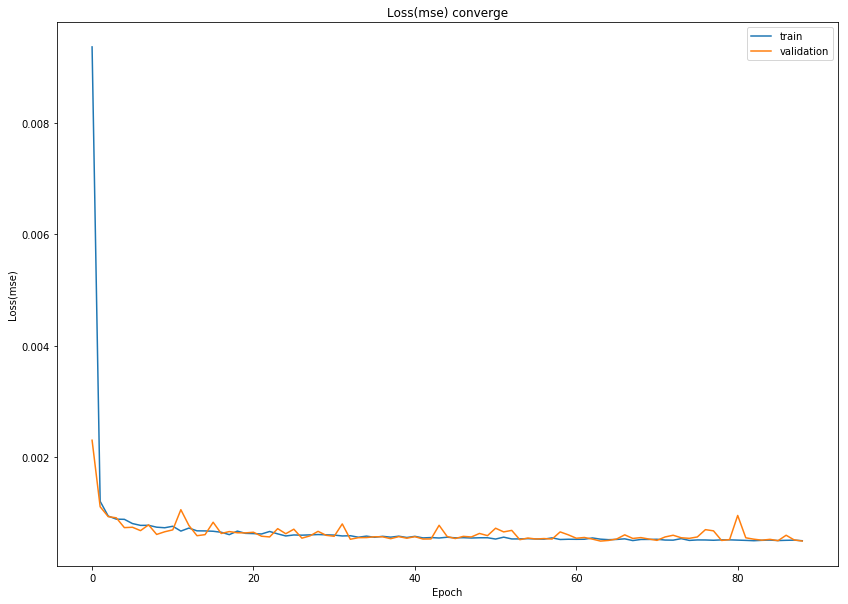

Wall time: 10min 37s


In [35]:
%time model_OTM, result_OTM = create_model(X_train_OTM, y_train_OTM)

,predicted,actual
0,16.094641,15.85
1,0.044572,0.06
2,1.037345,1.03
3,7.602365,7.55
4,0.403692,0.33
5,2.377292,2.28
6,4.982439,5.55
7,14.543966,14.50
8,4.833018,4.65
9,0.019953,0.05


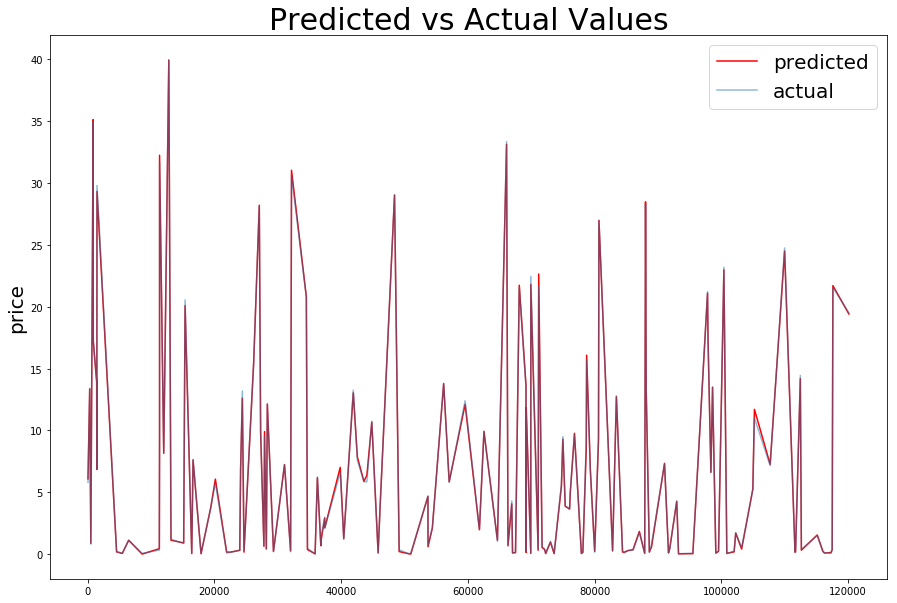

Mean absolute error (MAE): 0.134684
Mean squared error (MSE):  0.056398
R square (R^2):            0.999503


In [36]:
pred_OTM = pred(model_OTM, X_test_OTM, y_test_OTM, sc_X_OTM, sc_y_OTM)

In [37]:
model_OTM.save('model4_2_OTM.h5')

# Prediction

In [38]:
def load_prediction_data():
    df = pd.read_csv('Options_R_test.csv')
    df = df.dropna()
    
    # Calculate the intrinsic value of all the options
    df['intrinsic'] = df.apply(lambda row: intrinsic(row['underlying_price'], row['strike_price'], row['cp_flag_C'], row['cp_flag_P']), axis = 1)
    
    df['moneyness'] = df.apply(lambda row: moneyness(row['underlying_price'], row['strike_price']), axis = 1)
    
    df[['strike_price', 'underlying_price', 'maturity', 'impl_volatility', 'realized_vol', 'cp_flag_C', 'cp_flag_P', 
                    'interest_rate', 'intrinsic', 'moneyness', 'best_offer']].apply(pd.to_numeric)
    #sample_df = sample_df.reset_index(drop=True)
    ITM_df = df[df['moneyness'] <= 0.97]
    ATM_df = df[df['moneyness'].between(0.97, 1.03, inclusive = False)]
    OTM_df = df[df['moneyness'] >= 1.03]
    
    return df, ITM_df, ATM_df, OTM_df

In [41]:
p_df, p_df_ITM, p_df_ATM, p_df_OTM = load_prediction_data()

In [59]:
def model_pred(df, model, vol):
    
    y = df['best_offer'].values
    X = df[[ 'intrinsic', 'strike_price', 'underlying_price', 'maturity', vol, 'cp_flag_P', 'interest_rate',]]
    
    sc_X = StandardScaler()
    sc_X.fit(X)
    X_scale = sc_X.transform(X)

    sc_y = StandardScaler()
    y = y.reshape(-1,1)
    sc_y.fit(y)
    y_scale = sc_y.fit_transform(y)
    
    pred = model.predict(X_scale)
    
    pred = pred.flatten()
    y_scale = y_scale.flatten()
    y = y.flatten()
    y_pred = sc_y.inverse_transform(pred)
    
    d = {'predicted_scale': pred, 'actual_scale': y_scale, 'predict': y_pred, 'actual':y}
    datanew = pd.DataFrame(data = d)
    display(datanew.head(10))
      
    sample_data = datanew.sample(n=150)
    
    sample_data.sort_index(axis = 0, inplace = True)
    
    plt.figure(figsize = (15,10))
    plt.plot(sample_data.index, sample_data['predict'], linestyle = '-', label = 'predicted', color = 'r')
    plt.plot(sample_data.index, sample_data['actual'], linestyle = '-', label = 'actual', alpha = 0.5)
    plt.ylabel('price', fontsize = 20)
    plt.legend(prop={'size': 20})
    plt.title('Predicted vs Actual Values', fontsize = 30)
    plt.show()
    
    
    #print("Average sum error:              %f" % mean_sum_error(y, y_pred))
    print("Mean absolute error (MAE):      %f" % skm.mean_absolute_error(y, y_pred))
    print("Mean squared error (MSE):       %f" % skm.mean_squared_error(y, y_pred))
    #print("Root mean squared error (RMSE): %f" % math.sqrt(skm.mean_squared_error(y, y_pred)))
    print("R square (R^2):                 %f" % skm.r2_score(y, y_pred))

,predicted_scale,actual_scale,predict,actual
0,-0.526574,-0.479154,-0.725752,0.13
1,-0.533234,-0.479154,-0.845933,0.13
2,-0.486198,-0.483033,0.002877,0.06
3,-0.489831,-0.484141,-0.062687,0.04
4,-0.491784,-0.484695,-0.097916,0.03
5,-0.495508,-0.484695,-0.165128,0.03
6,-0.495225,-0.484695,-0.160020,0.03
7,-0.500538,-0.485249,-0.255893,0.02
8,-0.499372,-0.483033,-0.234859,0.06
9,-0.503036,-0.483587,-0.300987,0.05


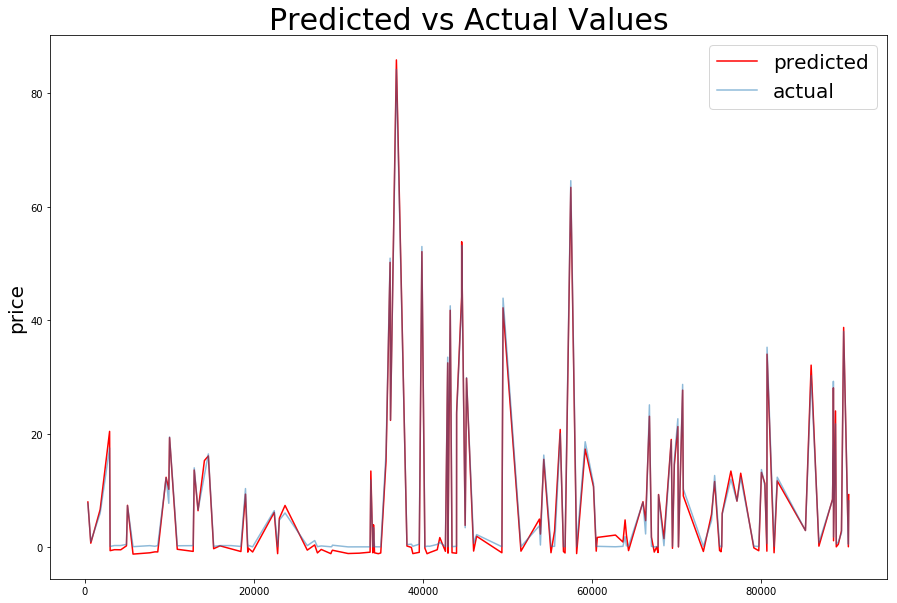

Mean absolute error (MAE):      0.981528
Mean squared error (MSE):       1.521588
R square (R^2):                 0.995328


In [60]:
model_pred(p_df_ITM, model_ITM, 'impl_volatility')

,predicted_scale,actual_scale,predict,actual
0,-0.556409,-0.479154,-1.264152,0.13
1,-0.554945,-0.479154,-1.237735,0.13
2,-0.492663,-0.483033,-0.113785,0.06
3,-0.497167,-0.484141,-0.195061,0.04
4,-0.501594,-0.484695,-0.274964,0.03
5,-0.505948,-0.484695,-0.353523,0.03
6,-0.510223,-0.484695,-0.430684,0.03
7,-0.514418,-0.485249,-0.506380,0.02
8,-0.518544,-0.483033,-0.580838,0.06
9,-0.522745,-0.483587,-0.656653,0.05


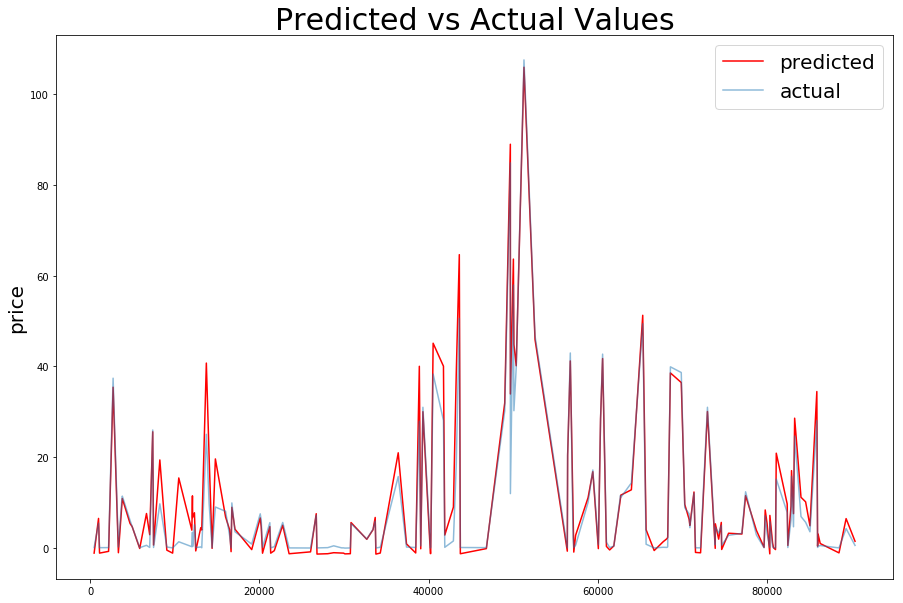

Mean absolute error (MAE):      1.981629
Mean squared error (MSE):       11.137064
R square (R^2):                 0.965802


In [61]:
model_pred(p_df_ITM, model_ITM, 'realized_vol')

,predicted_scale,actual_scale,predict,actual
0,-0.215299,-0.398395,2.316743,1.70
1,-0.340656,-0.514176,1.894490,1.31
2,-0.432340,-0.621052,1.585659,0.95
3,-0.504042,-0.707145,1.344136,0.66
4,-0.557159,-0.772458,1.165217,0.44
5,-0.616878,-0.819958,0.964058,0.28
6,-0.670792,-0.852614,0.782453,0.17
7,-0.718637,-0.873396,0.621293,0.10
8,-0.658074,-0.802146,0.825294,0.34
9,-0.614846,-0.760583,0.970903,0.48


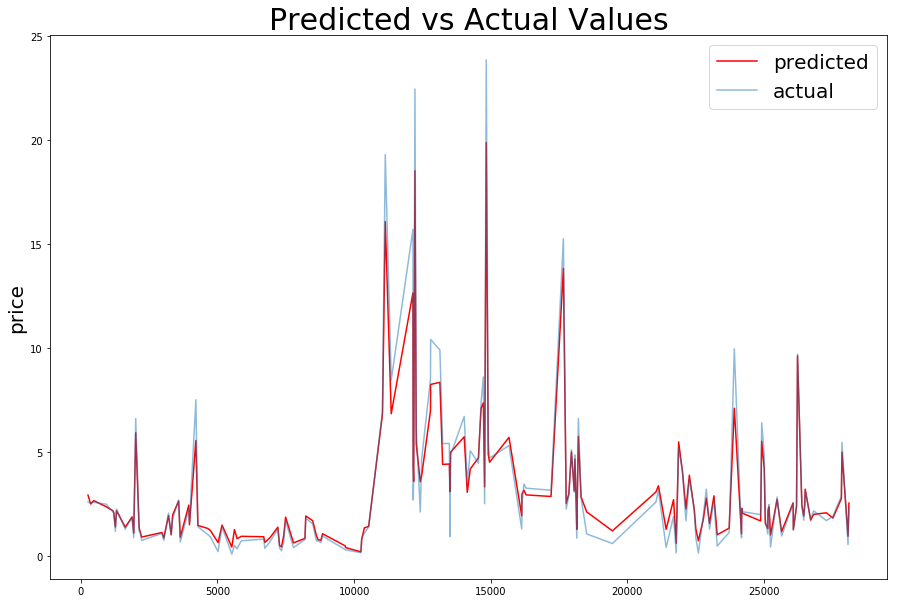

Mean absolute error (MAE):      0.450357
Mean squared error (MSE):       0.581037
R square (R^2):                 0.948790


In [62]:
model_pred(p_df_ATM, model_ATM, 'impl_volatility')

,predicted_scale,actual_scale,predict,actual
0,-0.237629,-0.398395,2.241527,1.70
1,-0.343605,-0.514176,1.884556,1.31
2,-0.442046,-0.621052,1.552966,0.95
3,-0.542221,-0.707145,1.215534,0.66
4,-0.598077,-0.772458,1.027389,0.44
5,-0.650831,-0.819958,0.849690,0.28
6,-0.706040,-0.852614,0.663723,0.17
7,-0.748281,-0.873396,0.521437,0.10
8,-0.739722,-0.802146,0.550268,0.34
9,-0.693312,-0.760583,0.706598,0.48


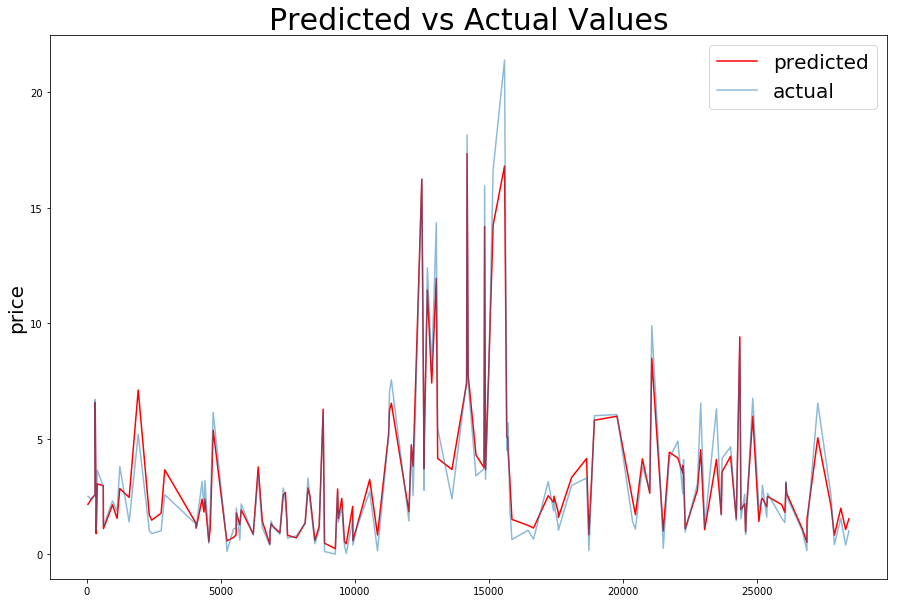

Mean absolute error (MAE):      0.519426
Mean squared error (MSE):       0.537236
R square (R^2):                 0.952651


In [63]:
model_pred(p_df_ATM, model_ATM, 'realized_vol')

,predicted_scale,actual_scale,predict,actual
0,-0.639884,-0.576554,-0.701586,0.14
1,-0.636159,-0.577306,-0.652079,0.13
2,-0.622629,-0.578059,-0.472287,0.12
3,-0.628448,-0.582574,-0.549614,0.06
4,-0.620502,-0.585584,-0.444023,0.02
5,-0.600393,-0.584079,-0.176798,0.04
6,-0.584799,-0.583326,0.030430,0.05
7,-0.563676,-0.582574,0.311133,0.06
8,-0.546412,-0.581069,0.540552,0.08
9,-0.535226,-0.579564,0.689203,0.10


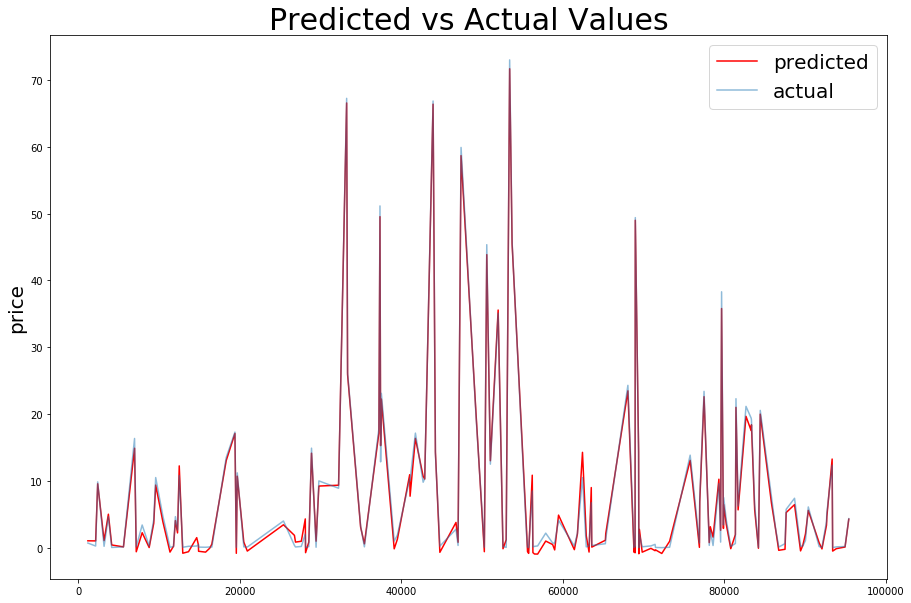

Mean absolute error (MAE):      0.806201
Mean squared error (MSE):       1.033133
R square (R^2):                 0.994150


In [64]:
model_pred(p_df_OTM, model_OTM, 'impl_volatility')

,predicted_scale,actual_scale,predict,actual
0,-0.672446,-0.576554,-1.134296,0.14
1,-0.671227,-0.577306,-1.118098,0.13
2,-0.664844,-0.578059,-1.033273,0.12
3,-0.655232,-0.582574,-0.905550,0.06
4,-0.643174,-0.585584,-0.745307,0.02
5,-0.616922,-0.584079,-0.396451,0.04
6,-0.603295,-0.583326,-0.215362,0.05
7,-0.585419,-0.582574,0.022200,0.06
8,-0.561055,-0.581069,0.345961,0.08
9,-0.547335,-0.579564,0.528285,0.10


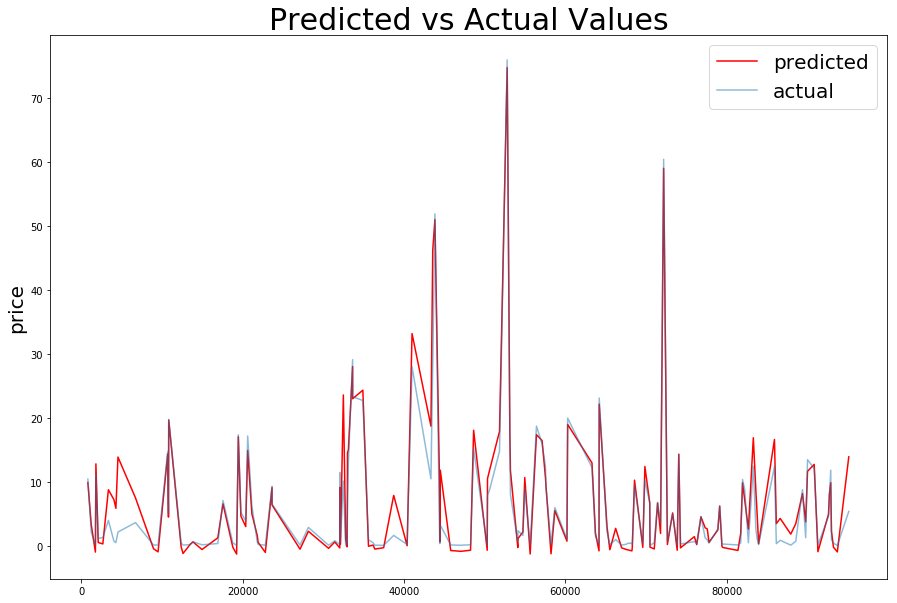

Mean absolute error (MAE):      1.982168
Mean squared error (MSE):       11.569923
R square (R^2):                 0.934483


In [65]:
model_pred(p_df_OTM, model_OTM, 'realized_vol')

## Reference: 
&emsp;&emsp;What does 'Accuracy' mean in Regression? https://github.com/keras-team/keras/issues/7947 <br>
&emsp;&emsp;https://keras.io/metrics/<br>
&emsp;&emsp;Scale, Standardize, or Normalize with Scikit-Learn https://towardsdatascience.com/scale-standardize-or-normalize-with-scikit-learn-6ccc7d176a02 <br>
&emsp;&emsp;The Day my Computer Won the Nobel Prize (Neural Network Option Pricing)  https://medium.com/datadriveninvestor/the-day-my-computer-won-the-nobel-prize-neural-network-option-pricing-d29b4379f1d2 <br>